## Time evolving leaf CN vs CO2

- this notebook analyzes global runs of CLM data for 3 cases:
  - Relationship between leaf CN and CO2 has a slope of 20
  - Control case where CN vs CO2 has slope 0
  - CLM leaf CN flexibility parameter is altered

First read in necessary packages: 

In [1]:
#Load necessary packages for data visualization 
import xarray as xr
from ctsm_py import utils
#import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date
import dask 

#some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os,sys

%matplotlib inline


In [2]:
xr.__version__

'2022.3.0'

In [2]:
# User defined options
model = 'CLM5_GSWP3'

archive = '/glade/scratch/wwieder/archive/'
caseShort = ['cnSlope0', 'cnSlope20', 'cn_flex_c']
cases = ['ctsm51d074_2deg_GSWP3V1_hist_'+short for short in caseShort]
path = '/lnd/hist/'
fin = [archive + case + path + "concat/" + case + '_cat.nc' for case in cases]
print(fin[0])

# Read in files for .area and .landfrac
fin2 = [archive + case + path + case + '.clm2.h0.1850-01.nc' for case in cases]
print(fin2[0])

/glade/scratch/wwieder/archive/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0/lnd/hist/concat/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0_cat.nc
/glade/scratch/wwieder/archive/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0/lnd/hist/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0.clm2.h0.1850-01.nc


### Read in data

In [3]:
# Read in data, time and time_bounds just used for utils.time_set_mid
var = ['NPP', 'GPP', 'LEAFCN', 'EFLX_LH_TOT', 'TOTVEGC', 'ELAI', 'TOTLITC','TOTLITN','FPI', 'NET_NMIN', 'NFIX',
       'time', 'time_bounds']

'''select the variables we want to read in'''
def preprocess(ds, var=var):
    return ds[var]

# For slope 0
for i in range(len(cases)):
    dsIN = utils.time_set_mid(xr.open_mfdataset(fin[i], decode_times=True, preprocess = preprocess), 'time')
    LandDs = utils.time_set_mid(xr.open_mfdataset(fin2[i], decode_times=True), 'time')
    dsIN['area'] = LandDs.area
    dsIN['landfrac'] = LandDs.landfrac

    if i == 0:
        ds = dsIN
    else:
        ds = xr.concat([ds,dsIN],"case",data_vars='all')


ds = ds.assign_coords(case=("case", caseShort))
ds = ds[['NPP', 'GPP', 'LEAFCN', 'EFLX_LH_TOT', 'TOTVEGC', 'ELAI', 'TOTLITC','TOTLITN','NET_NMIN','FPI', 'NFIX']]
#ds = ds.load()  # this may make things really slow now, but hopefully faster later on
ds

<xarray.Dataset>
Dimensions:      (case: 3, time: 1980, lat: 96, lon: 144)
Coordinates:
  * time         (time) object 1850-01-16 11:44:59.999993 ... 2014-12-16 12:0...
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * case         (case) <U9 'cnSlope0' 'cnSlope20' 'cn_flex_c'
Data variables:
    NPP          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    GPP          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    LEAFCN       (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT  (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    TOTVEGC      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    ELAI         (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    TOTLITC      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    TOTLITN      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NET_NMIN     (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    FPI          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NFIX         (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
Attributes: (12/100)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Apr 25 05:33:00 2022: ncrcat ct...
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    NCO:                                  netCDF Operators version 5.0.3 (Hom...

## Making time series plots and global maps
 - find annual averages
 - plot time series 
 - plot maps

#### Helpful notebooks for time series plotting
 - https://github.com/wwieder/ctsm_py/blob/master/notebooks/SimpleExample.ipynb
 - https://github.com/wwieder/ctsm_py/blob/master/notebooks/SimpleExampleNfix.ipynb
 - https://github.com/wwieder/cesm-lens/blob/main/notebooks/lens_NBP.ipynb

### Convert monthly to annual

<xarray.Dataset>
Dimensions:      (time: 165, lon: 144, lat: 96, case: 3)
Coordinates:
  * time         (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * case         (case) <U9 'cnSlope0' 'cnSlope20' 'cn_flex_c'
Data variables:
    NPP          (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    GPP          (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    LEAFCN       (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    EFLX_LH_TOT  (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    TOTVEGC      (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    ELAI         (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    TOTLITC      (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    TOTLITN      (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    NET_NMIN     (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    FPI          (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>
    NFIX         (case, time, lat, lon) float64 dask.array<chunksize=(1, 165, 96, 144), meta=np.ndarray>

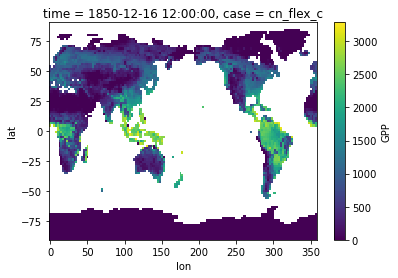

In [4]:
spy = 365 * 24 * 3600               # Convert  to annual fluxes (gC/m2/y), from gc/m2/s 
dsAnn = ds.apply(utils.weighted_annual_mean)
fluxes = ['GPP', 'NPP', 'NFIX', 'NET_NMIN']
for i in range(len(fluxes)):
    dsAnn[fluxes[i]] = dsAnn[fluxes[i]] * spy

dsAnn.GPP.isel(time=0, case=2).plot() ;
dsAnn

In [5]:
# this seems to take forever...
dsAnn = dsAnn.load()
print('loaded data to memory')

loaded data to memory


### Calculate CUE, 
where minimum of annual GPP > 10 

array([0.45414919, 0.45415849, 0.45937855])

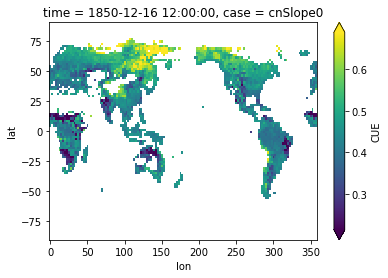

In [18]:
# sets minimum GPP, here 10 gC/m2/y,
# using a small value (> 0) prevents absure CUE calculations
minGPP = 10.
dsAnn['GPP'] = dsAnn.GPP.where(dsAnn.GPP.min('time') > minGPP)
dsAnn['CUE'] = dsAnn.NPP / dsAnn.GPP
dsAnn.CUE.isel(time=0, case=0).plot(robust=True)
dsAnn.CUE.mean(['lat', 'lon']).isel(time=0).values

### Calculate microbial C:N

array([43.84121927, 43.84121927, 44.03651849])

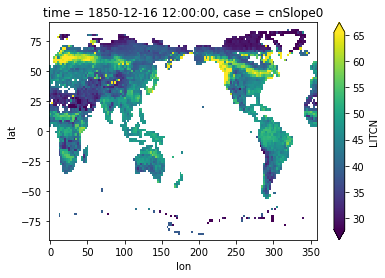

In [19]:
dsAnn['LITCN'] = dsAnn.TOTLITC / dsAnn.TOTLITN
#dsAnn.TOTMICN.values
dsAnn.LITCN.isel(time=0, case=0).plot(robust=True)
dsAnn.LITCN.mean(['lat', 'lon']).isel(time=10).values

### Check the time series 
gaps will appear if inf or -inf values are calculated

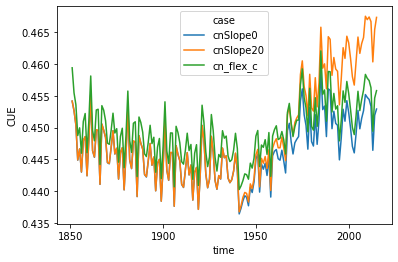

In [7]:
dsAnn.CUE.mean(['lat', 'lon']).plot(hue='case') ;
# Mask out absurd values if needed
# dsAnn['CUE'] = dsAnn.CUE.where(dsAnn.CUE > -1).where(dsAnn.CUE < 1)

### Make weights for global sum

sum area_wgt = 0.99999994


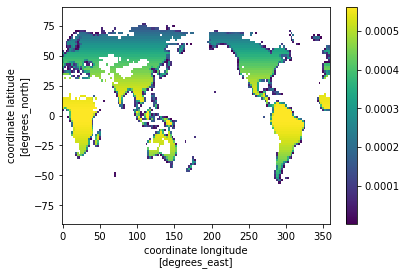

In [20]:
# only weight areas for grids with GPP>0
landUp = LandDs.area * LandDs.landfrac * 1e6      # area in km2, not m2
landUp = landUp.where(dsAnn.GPP.isel(case=0).min('time') > minGPP)
landUp.attrs['units'] = 'm^2'

# weighting for each grid cell
area_wgt = (landUp / landUp.sum()).drop('case')
area_wgt.plot()
print('sum area_wgt = '+ str(area_wgt.sum().values) )

### Calculate global sums

In [21]:
# ?? This could also be done regionally (see Paul's comments on google doc) ??
ann_glob = (dsAnn * landUp).sum(dim=('lat', 'lon'))

## 1 mm water = 1 kg/m2,  1e-15 for kg to Tt,  1e-15 gC to PgC,
# convert to Pg C/y, mm to Tt
Cvars = ['GPP','NPP','TOTVEGC', 'NFIX', 'NET_NMIN']
for i in range(len(Cvars)):
    ann_glob[Cvars[i]] = ann_glob[Cvars[i]] * 1e-15
    if Cvars[i] == 'TOTVEGC':
        ann_glob[Cvars[i]].attrs['units'] = 'Pg C'
    if Cvars[i] == ['NFIX', 'NET_NMIN']:
        ann_glob[Cvars[i]].attrs['units'] = 'Pg N'
    else:
        ann_glob[Cvars[i]].attrs['units'] = 'Pg C y^-1'

# area weighted mean
ann_Awgt = (dsAnn * area_wgt).sum(dim=('lat', 'lon'))


## Make a line plot

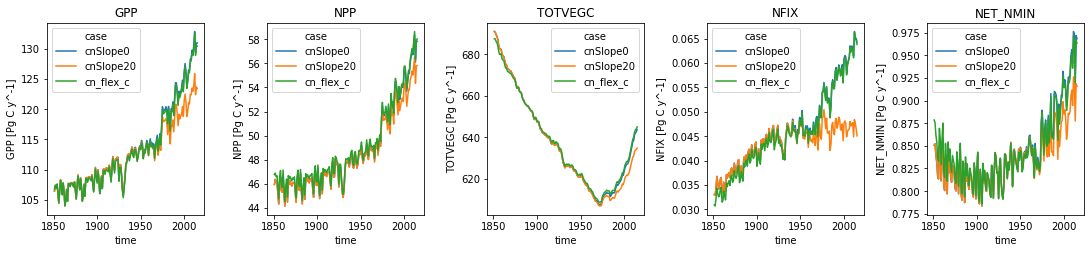

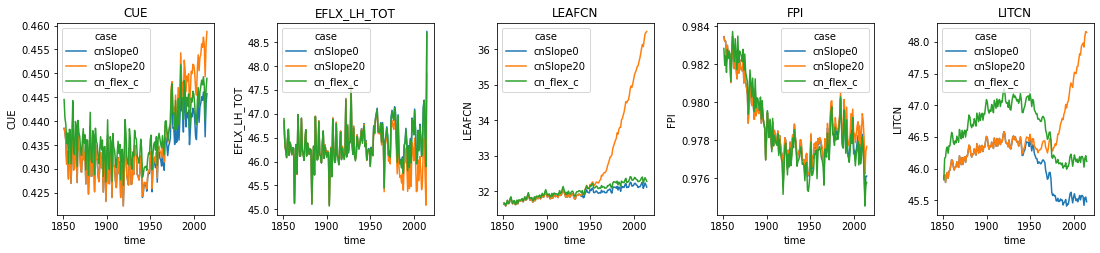

In [24]:
#quick plot , the `;` on the last line supresses text after executing the cell
vars = ['GPP', 'NPP', 'TOTVEGC', 'CUE', 'EFLX_LH_TOT', 'LEAFCN']
globVars = ['GPP', 'NPP', 'TOTVEGC', 'NFIX', 'NET_NMIN']
vars2 = ['CUE', 'EFLX_LH_TOT', 'LEAFCN', 'FPI', 'LITCN']

plt.figure(figsize=(18,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    ann_glob.get(globVars[i]).plot(hue='case')
    plt.title(globVars[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);

plt.figure(figsize=(18,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    ann_Awgt.get(vars2[i]).plot(hue='case')
    plt.title(vars2[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4);


    
# plt.subplot(232)
# ann_glob.NPP.plot(hue='case')


In [28]:
#ds.ELAI.where(ds.GPP.groupby('time.year').idxmax('time'))

### Make global difference maps
 - CUE
 - NPP
 - GPP
 - Total Veg C
 
 
For last 10 years of simulation


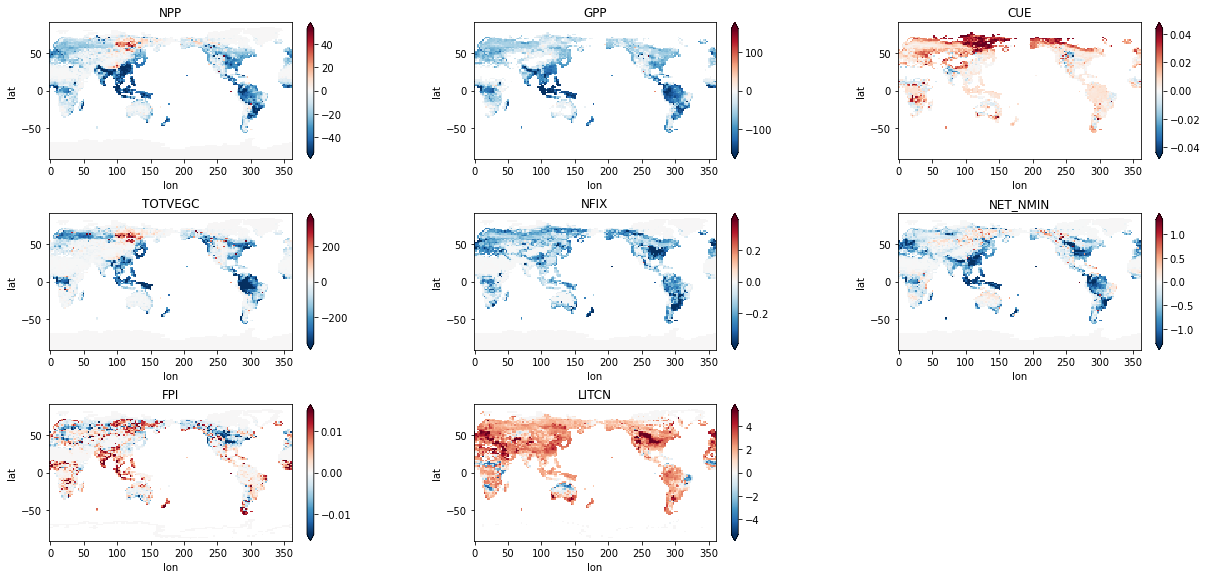

In [38]:
##Attempt global maps

mapVars = ['NPP', 'GPP','CUE', 'TOTVEGC', 'NFIX', 'NET_NMIN', 'FPI', 'LITCN']

plt.figure(figsize = (20,12))
for i in range(8):
    plt.subplot(3,3,1+i)
    z = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')[mapVars[i]]# Climatology for last 10 years of data
    z20 = dsAnn.isel(case=2,time=slice(-10,None)).mean('time')[mapVars[i]]
    zdiff = z - z20
    zdiff = utils.cyclic_dataarray(zdiff)
    lat = zdiff.coords['lat']
    lon = zdiff.coords['lon']
    zdiff.plot(robust = True) ;
     #ann_glob.get(globVars[i]).plot(hue='case')
    plt.title(mapVars[i])
    plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4);


In [21]:
z = ann_Awgt.isel(case=1,time=slice(-10,None))#.mean('time')['CUE']
x = dsAnn.isel(case=1,time=slice(-10,None))#.mean('time')['GPP']

ann_Awgt

<xarray.Dataset>
Dimensions:      (time: 165, case: 3)
Coordinates:
  * time         (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
  * case         (case) <U9 'cnSlope0' 'cnSlope20' 'cn_flex_c'
Data variables:
    NPP          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    GPP          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    LEAFCN       (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    EFLX_LH_TOT  (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    TOTVEGC      (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    ELAI         (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>
    CUE          (case, time) float64 dask.array<chunksize=(3, 165), meta=np.ndarray>

In [39]:
xdiff

<xarray.DataArray (lat: 96, lon: 145)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

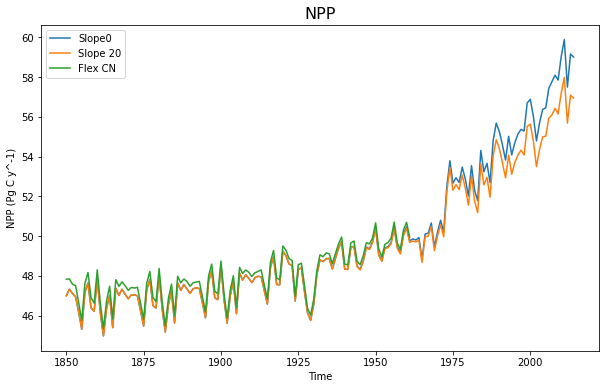

In [9]:
# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], NPP, label= 'Slope0')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('NPP' +' (' + ann_glob.attrs['units'] +')')
ax.set_title('NPP', fontdict={'size':16})
ax.legend(loc='upper left');

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob2.coords['time.year'], NPP2, label= 'Slope 20')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('LEAFCN' +' (' + ann_glob.attrs['units'] +')')
ax.set_title('NPP', fontdict={'size':16})
ax.legend(loc='upper left');


#Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob3.coords['time.year'], NPP3, label= 'Flex CN')
#Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('NPP' +' (' + ann_glob.attrs['units'] +')')
#ax.set_title(var, fontdict={'size':16})
ax.legend(loc='upper left');

### Plot GPP

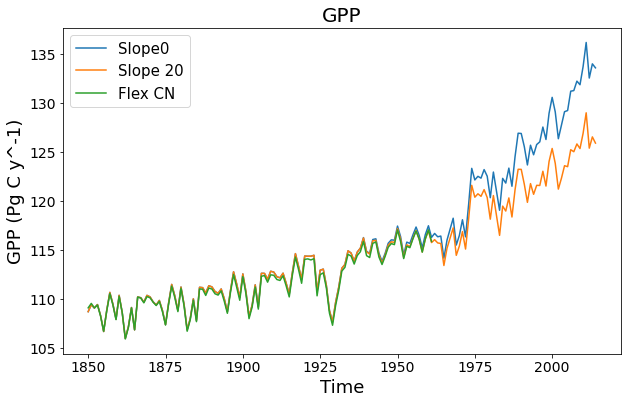

In [10]:
ds1 = ds.GPP
ds1 = ds1.to_dataset()

ds2 = ds20.GPP
ds2 = ds2.to_dataset()

ds3 = dsFlex.GPP
ds3 = ds3.to_dataset()

mean_dataset = ds1.apply(utils.weighted_annual_mean) * spy
#mean_dataset[var[0]].attrs['units'] = 'gN m-2 y-1'
mean_dataset.attrs['units'] = 'gC m-2 y-1'

mean_dataset2 = ds2.apply(utils.weighted_annual_mean) * spy
mean_dataset.attrs['units'] = 'gC m-2 y-1'

mean_dataset3 = ds3.apply(utils.weighted_annual_mean) * spy
mean_dataset.attrs['units'] = 'gC m-2 y-1'

mean_wgt = mean_dataset * landUp
ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob.attrs['units'] = 'Pg C y^-1'

mean_wgt2 = mean_dataset2 * landUp
ann_glob2 = mean_wgt2.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob2.attrs['units'] = 'Pg C y^-1'

mean_wgt3 = mean_dataset3 * landUp
ann_glob3 = mean_wgt3.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob3.attrs['units'] = 'Pg C y^-1'

### Make the plot 

NPP = ann_glob.GPP
NPP2 = ann_glob2.GPP
NPP3 = ann_glob3.GPP

# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], NPP, label= 'Slope0')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('GPP' +' (' + ann_glob.attrs['units'] +')')
ax.set_title('GPP', fontdict={'size':20})
ax.legend(loc='upper left');
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob2.coords['time.year'], NPP2, label= 'Slope 20')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('GPP' +' (' + ann_glob.attrs['units'] +')')
ax.set_title('GPP', fontdict={'size':20})
ax.legend(loc='upper left');


#Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob3.coords['time.year'], NPP3, label= 'Flex CN')
#Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('GPP' +' (' + ann_glob.attrs['units'] +')')
#ax.set_title(var, fontdict={'size':20})
ax.legend(loc='upper left', fontsize = 15);
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)


## Plot Total Veg C

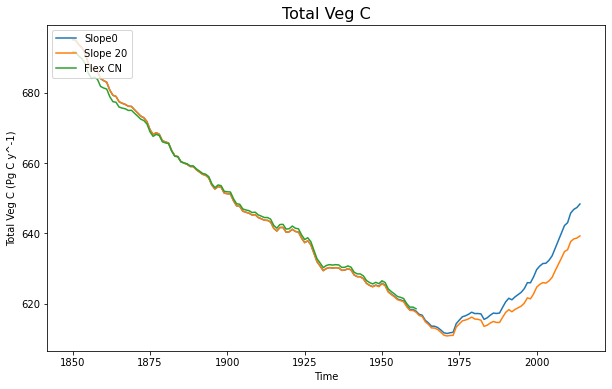

In [11]:
ds1 = ds.TOTVEGC
ds1 = ds1.to_dataset()

ds2 = ds20.TOTVEGC
ds2 = ds2.to_dataset()

ds3 = dsFlex.TOTVEGC
ds3 = ds3.to_dataset()

mean_dataset = ds1.apply(utils.weighted_annual_mean)
#mean_dataset[var[0]].attrs['units'] = 'gN m-2 y-1'
mean_dataset.attrs['units'] = 'gC m-2 y-1'

mean_dataset2 = ds2.apply(utils.weighted_annual_mean)
mean_dataset.attrs['units'] = 'gC m-2 y-1'

mean_dataset3 = ds3.apply(utils.weighted_annual_mean)
mean_dataset.attrs['units'] = 'gC m-2 y-1'

mean_wgt = mean_dataset * landUp
ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob.attrs['units'] = 'Pg C y^-1'

mean_wgt2 = mean_dataset2 * landUp
ann_glob2 = mean_wgt2.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob2.attrs['units'] = 'Pg C y^-1'

mean_wgt3 = mean_dataset3 * landUp
ann_glob3 = mean_wgt3.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob3.attrs['units'] = 'Pg C y^-1'

### Make the plot 

NPP = ann_glob.TOTVEGC
NPP2 = ann_glob2.TOTVEGC
NPP3 = ann_glob3.TOTVEGC

# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], NPP, label= 'Slope0')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('Total Veg C' +' (' + ann_glob.attrs['units'] +')')
ax.set_title('Total Veg C', fontdict={'size':16})
ax.legend(loc='upper left');

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob2.coords['time.year'], NPP2, label= 'Slope 20')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('Total Veg C' +' (' + ann_glob.attrs['units'] +')')
ax.set_title('Total Veg C', fontdict={'size':16})
ax.legend(loc='upper left');


#Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob3.coords['time.year'], NPP3, label= 'Flex CN')
#Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('Total Veg C' +' (' + ann_glob.attrs['units'] +')')
#ax.set_title(var, fontdict={'size':16})
ax.legend(loc='upper left');

## Plot Leaf CN

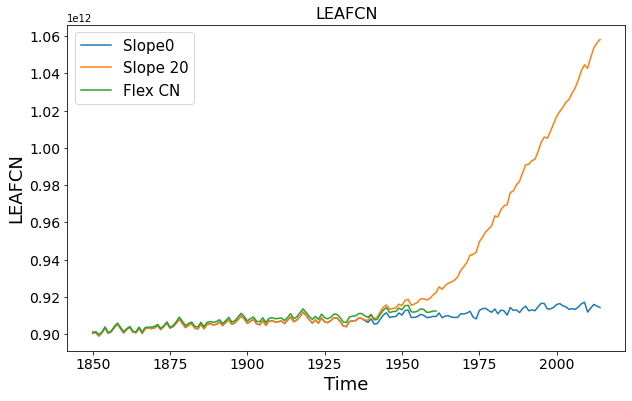

In [12]:
mean_dataset3 = da.apply(utils.weighted_annual_mean)
mean_dataset4 = da2.apply(utils.weighted_annual_mean)
mean_dataset5 = da3.apply(utils.weighted_annual_mean)

#print(mean_dataset3.ELAI.values)
# Max = da.groupby('time.year').max()
# MaxLAI = Max.ELAI
# print(MaxLAI.values)

mean_wgt = mean_dataset3 * landUp
ann_glob = mean_wgt.mean(dim=('lat','lon')) #* 1e-15 #convert to Pg/y

mean_wgt2 = mean_dataset4 * landUp
ann_glob2 = mean_wgt2.mean(dim=('lat','lon')) #* 1e-15 #convert to Pg/y

mean_wgt3 = mean_dataset5 * landUp
ann_glob3 = mean_wgt3.mean(dim=('lat','lon')) #* 1e-15 #convert to Pg/y

# ### Make the plot 

NPP = ann_glob.LEAFCN
NPP2 = ann_glob2.LEAFCN
NPP3 = ann_glob3.LEAFCN

# # Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# # Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# # Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob['time.year'], NPP, label= 'Slope0') 
# # Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('LEAFCN')
ax.set_title('LEAFCN', fontdict={'size':16})

# # Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob2.coords['time.year'], NPP2, label= 'Slope 20') 
ax.plot(ann_glob3.coords['time.year'], NPP3, label= 'Flex CN') 
ax.legend(loc='upper left') ;
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(loc='upper left', fontsize = 15);
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

In [37]:
#print(MaxLAI)
print(MaxLAI)

<xarray.DataArray 'ELAI' (time: 1980, lat: 96, lon: 144)>
dask.array<concatenate, shape=(1980, 96, 144), dtype=float32, chunksize=(12, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 11:44:59.999993 ... 2014-12-16 12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
    year     (time) int64 1850 1850 1850 1850 1850 ... 2014 2014 2014 2014 2014


In [40]:
##Find yearly max of ELAI and subset LEAFCN in da, also do for da1 and da2

ControlMax = da.groupby('time.year').max('time')
anomalies = da.groupby('time.year')- ControlMax
MaxLAI = anomalies.ELAI
daMax = da.where(da.ELAI == MaxLAI)
landup2 = landUp.where(daMax.ELAI.max('time')>0) #lat long, 2d
area_wgt = landup2 / landup2.sum()
daMax = daMax * area_wgt # includes non veg cells 
daMax = daMax.sum(dim=('lat','lon'))


/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


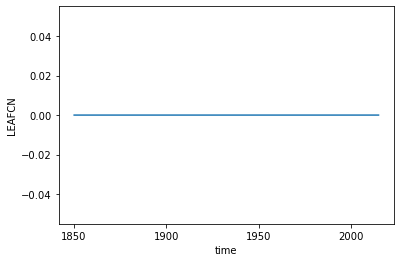

In [41]:
##Now make plot of LEAFCN using new daMax subset

daMax.LEAFCN.plot()

# LeafCN = daMax.LEAFCN
# # NPP2 = ann_glob2.LEAFCN
# # NPP3 = ann_glob3.LEAFCN

# # # Create a nicer figure
# fig = plt.figure(figsize=(10, 6))

# # # Ask, out of a 1x1 grid, the first axes.
# ax = fig.add_subplot(1, 1, 1)

# # # Plot times as x-variable and temperatures as y-variable
# ax.plot(daMax['year'], LeafCN, label= 'Slope0') 
# # # Add some labels to the plot
# ax.set_xlabel('Time')
# ax.set_ylabel('LEAFCN')
# ax.set_title('LEAFCN', fontdict={'size':16})

# # Plot times as x-variable and temperatures as y-variable
# ax.plot(ann_glob2.coords['time.year'], NPP2, label= 'Slope 20') 
# ax.plot(ann_glob3.coords['time.year'], NPP3, label= 'Flex CN') 
# ax.legend(loc='upper left') ;
# ax.xaxis.label.set_size(18)
# ax.yaxis.label.set_size(18)
# ax.legend(loc='upper left', fontsize = 15);
# ax.yaxis.set_tick_params(labelsize = 14)
# ax.xaxis.set_tick_params(labelsize = 14)

## Plot a map

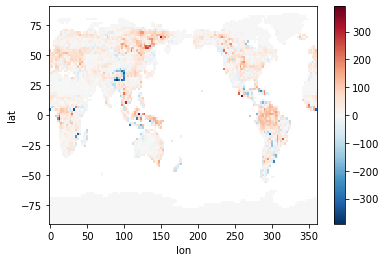

In [57]:
# making a data array, because cyclic_dataarray currently set up that way
x1= mean_dataset.isel(time=slice(0,10)).mean('time')['NPP'] # Climatology for first 10 years of data
x = mean_dataset.isel(time=slice(-10,None)).mean('time')['NPP'] # Climatology for last 10 years of data
xdiff = x - x1

xinit     = x1 * landUp
xfin      = x  * landUp
xdelta    = xdiff * landUp

glob_init   = xinit.sum(dim=('lat','lon')) * 1e-12 #convert to Tg/y
glob_fin    = xfin.sum(dim=('lat','lon')) * 1e-12 #convert to Tg/y
glob_change = xdelta.sum(dim=('lat','lon')) * 1e-12 #convert to TPg/y
#print(glob_init, glob_fin, glob_change)

# Then add cyclic point, ?? is there a better way to do this ??
x1= utils.cyclic_dataarray(x1)  
x = utils.cyclic_dataarray(x)
xdiff = utils.cyclic_dataarray(xdiff)
lat = xdiff.coords['lat']
lon = xdiff.coords['lon']
xdiff.plot() ;

### Making CUE plots, time series and maps

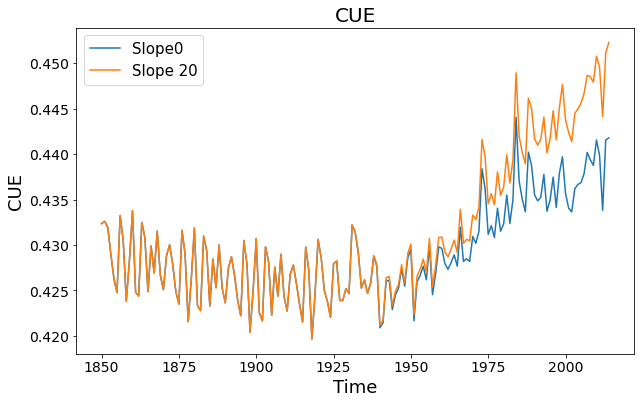

In [47]:
##Use annual averages
#mean_dataset
#mean_dataset2
#mean_dataset3
##Did this using division of global averages instead of division at the grid cell level. Would like to try to get this to work at the gridcell level but keep running into nan/inf problem. 

NPP = ann_glob.NPP/ann_glob.GPP
NPP2 = ann_glob2.NPP/ann_glob2.GPP

# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], NPP, label= 'Slope0')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('CUE')#+' (' + ann_glob.attrs['units'] +')')
ax.set_title('CUE', fontdict={'size':20})
ax.legend(loc='upper left');
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob2.coords['time.year'], NPP2, label= 'Slope 20')
ax.legend(loc='upper left', fontsize = 15);
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

In [46]:
##Attempt at global maps
# making a data array, because cyclic_dataarray currently set up that way
#x1= mean_dataset.isel(time=slice(0,10)).mean('time')['NPP'] # Climatology for first 10 years of data
x = mean_dataset.isel(time=slice(-10,None)).mean('time')['NPP'/ 'GPP']# Climatology for last 10 years of data
x20 = mean_dataset2.isel(time=slice(-10,None)).mean('time')['NPP'/'GPP']
xdiff = x - x20

xcont     = x * landUp
xCN      = x20  * landUp
xdelta    = xdiff * landUp

glob_cont   = xcont.sum(dim=('lat','lon')) * 1e-12 #convert to Tg/y
glob_CN    = xCN.sum(dim=('lat','lon')) * 1e-12 #convert to Tg/y
glob_change = xdelta.sum(dim=('lat','lon')) * 1e-12 #convert to TPg/y
#print(glob_cont, glob_CN, glob_change)

# Then add cyclic point, ?? is there a better way to do this ??
x20 = utils.cyclic_dataarray(x20)  
x = utils.cyclic_dataarray(x)
xdiff = utils.cyclic_dataarray(xdiff)
lat = xdiff.coords['lat']
lon = xdiff.coords['lon']
xdiff.plot() ;

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [21]:
print(ann_glob.GPP.values)

[108.7104554  109.41763208 109.08207148 109.4369776  108.31164742
 106.68357165 108.85634529 110.67281946 109.47225331 107.94126825
 110.37561089 108.62471837 105.99091423 107.1803046  109.13219312
 106.85492473 110.20782964 110.13261524 109.68285855 110.37208593
 110.21480628 109.70774301 109.39356704 109.85317951 108.84333869
 107.38622837 109.59392413 111.48645054 110.32944439 108.83350308
 111.22160059 109.44217005 106.85742804 108.0162012  110.01654397
 107.80999954 111.19357271 111.15870444 110.61917877 111.34839336
 111.23696764 110.76752542 110.57829581 111.02179718 110.02877017
 108.69586192 110.86807449 112.77378466 111.54754165 110.14805464
 112.55782843 110.76248969 108.21196547 109.37258895 111.44164929
 109.1742578  112.61725493 112.60968353 112.02651377 112.82814091
 112.74468853 112.26857211 112.16288646 112.63157858 111.62227871
 110.51092115 112.68041807 114.62684801 113.35161572 112.01776549
 114.37718564 114.36093825 114.36378689 114.45586606 110.73507852
 112.93533